<a href="https://www.kaggle.com/code/joanwachuka/ksl-sign?scriptVersionId=294997388" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ksl-hand-landmarks/dataset/mother/mother_12.npy
/kaggle/input/ksl-hand-landmarks/dataset/mother/mother_9.npy
/kaggle/input/ksl-hand-landmarks/dataset/mother/mother_21.npy
/kaggle/input/ksl-hand-landmarks/dataset/mother/mother_5.npy
/kaggle/input/ksl-hand-landmarks/dataset/mother/mother_22.npy
/kaggle/input/ksl-hand-landmarks/dataset/mother/mother_16.npy
/kaggle/input/ksl-hand-landmarks/dataset/mother/mother_1.npy
/kaggle/input/ksl-hand-landmarks/dataset/mother/mother_11.npy
/kaggle/input/ksl-hand-landmarks/dataset/mother/mother_3.npy
/kaggle/input/ksl-hand-landmarks/dataset/mother/mother_10.npy
/kaggle/input/ksl-hand-landmarks/dataset/mother/mother_2.npy
/kaggle/input/ksl-hand-landmarks/dataset/mother/mother_18.npy
/kaggle/input/ksl-hand-landmarks/dataset/mother/mother_7.npy
/kaggle/input/ksl-hand-landmarks/dataset/mother/mother_14.npy
/kaggle/input/ksl-hand-landmarks/dataset/mother/mother_15.npy
/kaggle/input/ksl-hand-landmarks/dataset/mother/mother_8.npy
/kaggle/input/k

In [2]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout ,Normalization , BatchNormalization, Bidirectional, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

2026-01-30 17:01:33.802905: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769792493.990402      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769792494.045915      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769792494.491641      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769792494.491688      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769792494.491691      24 computation_placer.cc:177] computation placer alr

In [3]:

DATA_PATH = "/kaggle/input/ksl-hand-landmarks/dataset"
MAX_FRAMES = 60
FEATURES = 126
EPOCHS = 20  
BATCH_SIZE = 16
LEARNING_RATE = 0.001
LABELS = ['a', 'is', 'mother', 'my', 'this'] 

In [4]:
# Load data 
X, y = [], []
for label_idx, label in enumerate(LABELS):
    label_dir = os.path.join(DATA_PATH, label)
    for file in os.listdir(label_dir):
        if file.endswith('.npy'):
            seq = np.load(os.path.join(label_dir, file))
            X.append(seq)
            y.append(label_idx)


print("Number of sequences:", len(X))
print("Example sequence shape:", X[0].shape)

# Convert to arrays
X = np.array(X, dtype=object)
y = np.array(y)


# Pad sequences
X_padded = pad_sequences(X, maxlen=MAX_FRAMES, dtype='float32', padding='post', truncating='post')
y_onehot = to_categorical(y, num_classes=len(LABELS))
print("X shape after padding:", X_padded.shape)



Number of sequences: 101
Example sequence shape: (23, 126)
X shape after padding: (101, 60, 126)


In [5]:
# Train/val/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y_onehot, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42, stratify=np.argmax(y_test, axis=1)
)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("x_val shape:", X_val.shape)



norm = Normalization(axis=-1)
norm.adapt(X_train)

X_train shape: (70, 60, 126)
X_test shape: (16, 60, 126)
x_val shape: (15, 60, 126)


I0000 00:00:1769792508.830349      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [6]:


model = Sequential([
  
        Input(shape=(MAX_FRAMES, FEATURES)),
    
        Bidirectional(LSTM(32, return_sequences=True)),
        
        LSTM(16, return_sequences=False),
        BatchNormalization(),
        
        Dense(64, activation='relu'),
        #Dropout(0.4),
        
        Dense(32, activation='relu'),
        #Dropout(0.4),
        Dense(len(LABELS), activation='softmax')
    
    
])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
]

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 60, 64)         │        40,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,285 (192.52 KB)

 Trainable params: 49,253 (192.39 KB)

 Non-trainable params: 32 (128.00 B)

In [7]:

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)


test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n Test Accuracy: {test_acc:.4f}")


model.save("KSL_model.keras")
np.save("sign_labels.npy", np.array(LABELS))

print("Model and labels saved!")


Epoch 1/20


I0000 00:00:1769792514.252007      66 cuda_dnn.cc:529] Loaded cuDNN version 91002


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.1999 - loss: 1.6105 - val_accuracy: 0.2000 - val_loss: 1.6097 - learning_rate: 0.0010
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2355 - loss: 1.6053 - val_accuracy: 0.2000 - val_loss: 1.6095 - learning_rate: 0.0010
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2302 - loss: 1.6027 - val_accuracy: 0.2000 - val_loss: 1.6096 - learning_rate: 0.0010
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2489 - loss: 1.5941 - val_accuracy: 0.0667 - val_loss: 1.6096 - learning_rate: 0.0010
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3751 - loss: 1.5767 - val_accuracy: 0.0667 - val_loss: 1.6070 - learning_rate: 0.0010
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3048 - loss: 1.4703 - val_accuracy: 0.2667 - val_loss: 1.5870 - learning_rate: 0.0010
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3469 - loss: 1.3319 - val_accuracy: 0.2000 - val_loss


Evaluating best model...
Test Accuracy: 0.3750
Test Loss: 1.3600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step

Classification Report:
              precision    recall  f1-score   support

           a       0.00      0.00      0.00         4
          is       0.00      0.00      0.00         3
      mother       1.00      1.00      1.00         3
          my       0.50      1.00      0.67         3
        this       0.00      0.00      0.00         3

    accuracy                           0.38        16
   macro avg       0.30      0.40      0.33        16
weighted avg       0.28      0.38      0.31        16


Confusion Matrix:
[[0 0 0 0 4]
 [3 0 0 0 0]
 [0 0 3 0 0]
 [0 0 0 3 0]
 [0 0 0 3 0]]

cnfusion matrix heatmap


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


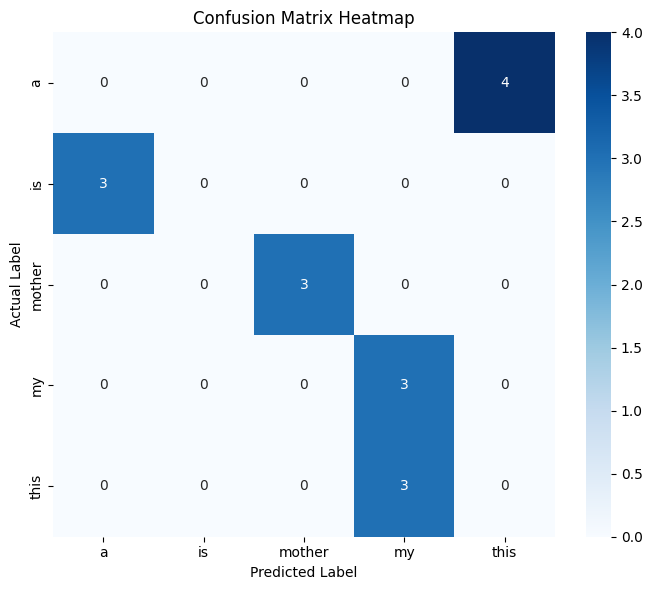

In [8]:
# Evaluate
print("\nEvaluating best model...")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Predict and show classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=LABELS))

print("\nConfusion Matrix:")
cm=confusion_matrix(y_true_classes, y_pred_classes)
print(cm)

print("\ncnfusion matrix heatmap")
# Plot heatmap
plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=LABELS,   # Predicted labels
    yticklabels=LABELS    # Actual labels
)

plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix Heatmap")
plt.tight_layout()
plt.show()



In [9]:
import numpy as np
from collections import defaultdict

# Convert one-hot y_test back to integers
y_test_int = np.argmax(y_test, axis=1)

# Group indices by class in the test set
indices_by_class = defaultdict(list)
for idx, label in enumerate(y_test_int):
    indices_by_class[label].append(idx)

# Select up to 3 samples per class
selected_indices = []
for label in range(len(LABELS)):
    if label in indices_by_class:
        selected = indices_by_class[label][:3]  
        selected_indices.extend(selected)

# Extract those samples
X_demo = X_test[selected_indices]
y_demo_true = y_test_int[selected_indices]

# Predict
y_demo_pred = model.predict(X_demo)
y_demo_pred_labels = np.argmax(y_demo_pred, axis=1)

# Print results
print("Manual test on 3 samples per class :\n")
for i, idx in enumerate(selected_indices):
    true_label = LABELS[y_demo_true[i]]
    pred_label = LABELS[y_demo_pred_labels[i]]
    confidence = np.max(y_demo_pred[i])
    status = "CORRECT" if true_label == pred_label else "WRONG"
    print(f"{status} Sample {i+1}: True='{true_label}' | Pred='{pred_label}' | Conf={confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
Manual test on 3 samples per class :

WRONG Sample 1: True='a' | Pred='this' | Conf=0.21
WRONG Sample 2: True='a' | Pred='this' | Conf=0.21
WRONG Sample 3: True='a' | Pred='this' | Conf=0.23
WRONG Sample 4: True='is' | Pred='a' | Conf=0.23
WRONG Sample 5: True='is' | Pred='a' | Conf=0.24
WRONG Sample 6: True='is' | Pred='a' | Conf=0.23
CORRECT Sample 7: True='mother' | Pred='mother' | Conf=0.27
CORRECT Sample 8: True='mother' | Pred='mother' | Conf=0.24
CORRECT Sample 9: True='mother' | Pred='mother' | Conf=0.25
CORRECT Sample 10: True='my' | Pred='my' | Conf=0.36
CORRECT Sample 11: True='my' | Pred='my' | Conf=0.36
CORRECT Sample 12: True='my' | Pred='my' | Conf=0.35
WRONG Sample 13: True='this' | Pred='my' | Conf=0.33
WRONG Sample 14: True='this' | Pred='my' | Conf=0.32
WRONG Sample 15: True='this' | Pred='my' | Conf=0.35
